In [1]:
import sys
import os
import os.path as osp

os.environ['PYOPENGL_PLATFORM'] = 'egl'

import matplotlib.pyplot as plt
import PIL.Image as pil_img
from threadpoolctl import threadpool_limits
from tqdm import tqdm
import trimesh
import torch
import time
import argparse
from collections import defaultdict
from loguru import logger
from collections import OrderedDict
import numpy as np
from omegaconf import OmegaConf, DictConfig

import resource

from human_shape.config.defaults import conf as default_conf
from human_shape.models.build import build_model
from human_shape.models.body_models import KeypointTensor
from human_shape.data import build_all_data_loaders
from human_shape.data.structures.image_list import to_image_list
from human_shape.utils import Checkpointer, COLORS, OverlayRenderer, HDRenderer


rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (rlimit[1], rlimit[1]))


def weak_persp_crop_to_blender(
        targets,
        camera_scale,
        camera_transl,
        crop_size,
        sensor_width=36,
        focal_length=5000):
    ''' Converts weak-perspective camera to a perspective camera
    '''
    if torch.is_tensor(camera_scale):
        camera_scale = camera_scale.detach().cpu().numpy()
    if torch.is_tensor(camera_transl):
        camera_transl = camera_transl.detach().cpu().numpy()

    output = defaultdict(lambda: [])
    for ii, target in enumerate(targets):
        z = 2 * focal_length / (camera_scale[ii] * crop_size)

        transl = [
            camera_transl[ii, 0].item(), camera_transl[ii, 1].item(), z]
        shift_x = 0.0
        shift_y = 0.0
        focal_length_in_mm = focal_length / crop_size * sensor_width
        output['shift_x'].append(shift_x)
        output['shift_y'].append(shift_y)
        output['transl'].append(transl)
        output['focal_length_in_mm'].append(focal_length_in_mm)
        output['focal_length_in_px'].append(focal_length)
        output['center'].append((0.5 * crop_size, 0.5 * crop_size))
        output['sensor_width'].append(sensor_width)
    for key in output:
        output[key] = np.array(output[key])
    return output


def weak_persp_to_blender(
        targets,
        camera_scale,
        camera_transl,
        H, W,
        sensor_width=36,
        focal_length=5000):
    ''' Converts weak-perspective camera to a perspective camera
    '''
    if torch.is_tensor(camera_scale):
        camera_scale = camera_scale.detach().cpu().numpy()
    if torch.is_tensor(camera_transl):
        camera_transl = camera_transl.detach().cpu().numpy()

    output = defaultdict(lambda: [])
    for ii, target in enumerate(targets):
        orig_bbox_size = target.get_field('orig_bbox_size')
        bbox_center = target.get_field('orig_center')
        z = 2 * focal_length / (camera_scale[ii] * orig_bbox_size)

        transl = [
            camera_transl[ii, 0].item(), camera_transl[ii, 1].item(),
            z.item()]
        shift_x = - (bbox_center[0] / W - 0.5)
        shift_y = (bbox_center[1] - 0.5 * H) / W
        focal_length_in_mm = focal_length / W * sensor_width
        output['shift_x'].append(shift_x)
        output['shift_y'].append(shift_y)
        output['transl'].append(transl)
        output['focal_length_in_mm'].append(focal_length_in_mm)
        output['focal_length_in_px'].append(focal_length)
        output['center'].append(bbox_center)
        output['sensor_width'].append(sensor_width)

    for key in output:
        output[key] = np.array(output[key])
    return output


def undo_img_normalization(image, mean, std, add_alpha=True):
    if torch.is_tensor(image):
        image = image.detach().cpu().numpy().squeeze()

    out_img = (image * std[np.newaxis, :, np.newaxis, np.newaxis] +
               mean[np.newaxis, :, np.newaxis, np.newaxis])
    if add_alpha:
        out_img = np.pad(
            out_img, [[0, 0], [0, 1], [0, 0], [0, 0]],
            mode='constant', constant_values=1.0)
    return out_img



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:
@torch.no_grad()
def main(
    exp_cfg: DictConfig,
    show: bool = False,
    demo_output_folder: os.PathLike = 'demo_output',
    pause: float = -1,
    focal_length: float = 5000,
    sensor_width: float = 36,
    save_vis: bool = True,
    save_params: bool = False,
    save_mesh: bool = False,
    split: str = 'test',
) -> None:

    device = torch.device('cuda')
    if not torch.cuda.is_available():
        logger.error('CUDA is not available!')
        sys.exit(3)

    # logger.remove()
    # logger.add(lambda x: tqdm.write(x, end=''),
    #            level=exp_cfg.logger_level.upper(),
    #            colorize=True)

    # output_folder = osp.expandvars(exp_cfg.output_folder)

    # os.makedirs(demo_output_folder, exist_ok=True)

    # log_file = osp.join(output_folder, 'info.log')
    # logger.add(log_file, level=exp_cfg.logger_level.upper(), colorize=True)

    model_dict = build_model(exp_cfg)
    model = model_dict['network']
    try:
        model = model.to(device=device)
    except RuntimeError:
        # Re-submit in case of a device error
        sys.exit(3)

    # checkpoint_folder = osp.join(output_folder, exp_cfg.checkpoint_folder)
    # if not osp.exists(checkpoint_folder):
    #     os.makedirs(checkpoint_folder)

    # checkpointer = Checkpointer(model, save_dir=checkpoint_folder,
    #                             pretrained=exp_cfg.pretrained)

    # arguments = {'iteration': 0, 'epoch_number': 0}
    # extra_checkpoint_data = checkpointer.load_checkpoint()
    # for key in arguments:
    #     if key in extra_checkpoint_data:
    #         arguments[key] = extra_checkpoint_data[key]

    model = model.eval()

    part_key = exp_cfg.get('part_key', 'pose')
    transf_cfg = exp_cfg.get('datasets', {}).get(part_key, {}).get(
        'transforms', {})
    means = np.array(transf_cfg.get('mean', (0.485, 0.456, 0.406)))
    std = np.array(transf_cfg.get('std', (0.229, 0.224, 0.225)))

    # render = save_vis or show
    # if render:
    #     body_renderer = OverlayRenderer(
    #         img_size=exp_cfg.datasets.pose.transforms.crop_size)
    #     hd_renderer = HDRenderer()

    dataloaders = build_all_data_loaders(
        exp_cfg, split=split, shuffle=False, enable_augment=False,
        return_full_imgs=True,
    )

    # part_key = exp_cfg.get('part_key', 'pose')

    print("###", type(dataloaders[part_key]))
    if isinstance(dataloaders[part_key], (list,)):
        assert len(dataloaders[part_key]) == 1
        body_dloader = dataloaders[part_key][0]
    else:
        body_dloader = dataloaders[part_key]
    #  if isinstance(dataloaders[part_key], (dict,)):
        #  body_dloader = dataloaders[part_key]
    #  elif isinstance(dataloaders[part_key], (list,)):
        #  assert len(dataloaders[part_key]) == 1
        #  body_dloader = dataloaders[part_key][0]

    # total_time = 0
    # cnt = 0
    # degrees = [0, 90, 180, 270]

    results = []
    for bidx, batch in enumerate(tqdm(body_dloader, dynamic_ncols=True, disable=True)):
        full_imgs_list, body_imgs, body_targets = batch
        #  if full_imgs_list is None:
            #  continue
        #filename = body_targets[0].get_field('filename')
        #subject_id = filename.split('/')[-3].split('_')[-3]
        #if subject_id not in ['03279', '02474']:
        #    continue

        if body_imgs is None:
            raise Exception("No body_imgs")
            continue

        full_imgs = to_image_list(full_imgs_list)
        body_imgs = body_imgs.to(device=device)
        body_targets = [target.to(device) for target in body_targets]
        if full_imgs is not None:
            full_imgs = full_imgs.to(device=device)

        torch.cuda.synchronize()
        # start = time.perf_counter()
        model_output = model(body_imgs, body_targets, full_imgs=full_imgs,
                             device=device)
        torch.cuda.synchronize()
        # elapsed = time.perf_counter() - start
        # cnt += 1
        # total_time += elapsed

        # hd_imgs = full_imgs.images.detach().cpu().numpy().squeeze()
        # body_imgs = body_imgs.detach().cpu().numpy()

        # _, _, H, W = full_imgs.shape
        # if render or True:
        #     hd_imgs = np.transpose(undo_img_normalization(hd_imgs, means, std),
        #                            [0, 2, 3, 1])
        #     hd_imgs = np.clip(hd_imgs, 0, 1.0)

        #     body_imgs = undo_img_normalization(body_imgs, means, std)
        #     body_imgs = np.clip(body_imgs, 0, 1.0)

        # stage_keys = model_output.get('stage_keys')
        # out_img = OrderedDict()
        # if save_vis:
        #     bg_hd_imgs = np.transpose(hd_imgs, [0, 3, 1, 2])
        #     out_img['hd_imgs'] = bg_hd_imgs
        # if 'predicted_images' in model_output:
        #     model_output['predicted_images'] = model_output['predicted_images']

        # for stage_key in tqdm(stage_keys, leave=False, disable=True):
        #     stage_n_out = model_output[stage_key]
        #     model_vertices = stage_n_out.get('vertices', None)
        #     if model_vertices is None:
        #         continue

        #     faces = stage_n_out['faces']
        #     model_vertices = model_vertices.detach().cpu().numpy()
        #     camera_parameters = model_output.get('camera_parameters', {})
        #     camera_scale = camera_parameters['scale'].detach()
        #     camera_transl = camera_parameters['translation'].detach()

        #     hd_params = weak_persp_to_blender(
        #         body_targets,
        #         camera_scale=camera_scale,
        #         camera_transl=camera_transl,
        #         H=H, W=W,
        #         sensor_width=sensor_width,
        #         focal_length=focal_length,
        #     )
        #     print("### hd_params", hd_params.keys())

        #     if render:
        #         # Render the initial predictions on the original image resolution
        #         body_color = COLORS.get(stage_key, COLORS['default'])
        #         overlays = hd_renderer(
        #             model_vertices, faces,
        #             focal_length=hd_params['focal_length_in_px'],
        #             camera_translation=hd_params['transl'],
        #             camera_center=hd_params['center'],
        #             bg_imgs=bg_hd_imgs,
        #             return_with_alpha=True,
        #             body_color=body_color,
        #         )
        #         out_img[f'hd_{stage_key}_overlay'] = overlays
        #         out_img[f'hd_{stage_key}_cat'] = np.concatenate(
        #             [bg_hd_imgs, overlays], axis=-1)

        # if save_vis:
        #     for key in out_img.keys():
        #         out_img[key] = np.clip(
        #             np.transpose(
        #                 out_img[key], [0, 2, 3, 1]) * 255, 0, 255).astype(
        #                     np.uint8)
        #         if 'left' in key:
        #             out_img[key] = out_img[key][:, :, ::-1, :]

        stage_n_out = model_output['stage_02']
        fname = body_targets[0].get_field('fname')
        print(f"### {fname} measurements", stage_n_out["measurements"])
        results.append((
        #  logger.info(stage_n_out.keys())
        # for idx in tqdm(range(len(body_targets)), 'Saving ...', disable=True):
        #     fname = body_targets[idx].get_field('fname')


        #     filename = body_targets[idx].get_field('filename', '')
        #     if filename != '':
        #         f1, f2 = filename.split('/')[-3:-1]
        #         curr_out_path = osp.join(demo_output_folder, f1, f2)
        #     else:
        #         curr_out_path = demo_output_folder

        #     imgfname = fname.split('.')[0]
        #     os.makedirs(curr_out_path, exist_ok=True)

        #     if save_vis:
        #         for name, curr_img in out_img.items():
        #             pil_img.fromarray(curr_img[idx]).save(
        #                 osp.join(curr_out_path, f'{imgfname}_{name}.png'))

        #     if save_mesh:
        #         # Store the body mesh
        #         mesh = trimesh.Trimesh(model_vertices[idx] +
        #                                hd_params['transl'][idx], faces,
        #                                process=False)
        #         mesh_fname = osp.join(curr_out_path,
        #                               f'{imgfname}.ply')
        #         mesh.export(mesh_fname)

        #     if save_params:
        #         params_fname = osp.join(curr_out_path, f'{imgfname}.npz')
        #         out_params = dict(fname=fname)

        #         for key, val in stage_n_out.items():
        #             if torch.is_tensor(val):
        #                 val = val.detach().cpu().numpy()[idx]
        #             elif isinstance(val, (KeypointTensor,)):
        #                 val = val._t[idx].detach().cpu().numpy()
        #             out_params[key] = val
        #         for key, val in hd_params.items():
        #             if torch.is_tensor(val):
        #                 val = val.detach().cpu().numpy()
        #             if np.isscalar(val[idx]):
        #                 out_params[key] = val[idx].item()
        #             else:
        #                 out_params[key] = val[idx]
        #         np.savez_compressed(params_fname, **out_params)

    # logger.info(f'Average inference time: {total_time / cnt}')


#  torch.multiprocessing.set_start_method('fork')
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

show = True
output_folder = '../samples/shapy_fit/'
pause = -1
focal_length = 5000
save_vis = True
save_params = True
save_mesh = True
split = "test"

cfg = default_conf.copy()

exp_cfgs = ["configs/b2a_expose_hrnet_demo.yaml"]

for exp_cfg in exp_cfgs:
    if exp_cfg:
        cfg.merge_with(OmegaConf.load(exp_cfg))

exp_opts = [
    "output_folder=../data/trained_models/shapy/SHAPY_A",
    "part_key=pose",
    "datasets.pose.openpose.data_folder=../samples",
    "datasets.pose.openpose.img_folder=images",
    "datasets.pose.openpose.keyp_folder=openpose",
    "datasets.batch_size=1",
    "datasets.pose_shape_ratio=1.0"
]

if exp_opts:
    cfg.merge_with(OmegaConf.from_cli(exp_opts))

cfg.is_training = False
#  cfg.datasets[part_key].splits.test = cmd_args.datasets
for part_key in ['pose', 'shape']:
    splits = cfg.datasets.get(part_key, {}).get('splits', {})
    if splits:
        splits['train'] = []
        splits['val'] = []
        splits['test'] = []
part_key = cfg.get('part_key', 'pose')

datasets = ["openpose"]
cfg.datasets[part_key].splits[split] = datasets

with threadpool_limits(limits=1):
    full_imgs_list, body_imgs, body_targets = main(cfg, show=show, demo_output_folder=output_folder, pause=pause,
         focal_length=focal_length,
         save_vis=save_vis,
         save_mesh=save_mesh,
         save_params=save_params,
         split=split,
         )
    print("DONE")

2024-11-07 21:04:03.684 | INFO     | human_shape.models.build:build_model:18 - Going to build a: SMPLXRegressor
2024-11-07 21:04:03.685 | INFO     | human_shape.models.body_heads.body_heads:__init__:221 - Predict face: False
2024-11-07 21:04:03.686 | INFO     | human_shape.models.body_heads.body_heads:__init__:146 - Predict hands: False
2024-11-07 21:04:03.687 | INFO     | human_shape.models.common.iterative_regressor:__init__:53 - Pose last stage: True
2024-11-07 21:04:03.689 | INFO     | human_shape.models.body_models.body_models:__init__:545 - Loading model from: ../data/body_models/smplx/SMPLX_NEUTRAL.npz
2024-11-07 21:04:04.330 | INFO     | human_shape.models.body_models.body_models:__init__:173 - Use joint regressor: True
2024-11-07 21:04:04.331 | INFO     | human_shape.models.body_models.body_models:__init__:175 - Loading joint regressor from: ../data/expose_release/data/SMPLX_to_J14.pkl
2024-11-07 21:04:04.344 | INFO     | human_shape.models.body_heads.body_heads:_build_model:5

TypeError: cannot unpack non-iterable NoneType object

In [15]:
torch.Tensor.data

<attribute 'data' of 'torch._C._TensorBase' objects>

In [59]:
type([target for target in body_targets][0])

human_shape.data.structures.keypoints.Keypoints2D

In [3]:
body_imgs.shape

torch.Size([1, 3, 256, 256])

In [28]:
np.swapaxes(body_imgs[0], 0, 2).shape

(256, 256, 4)

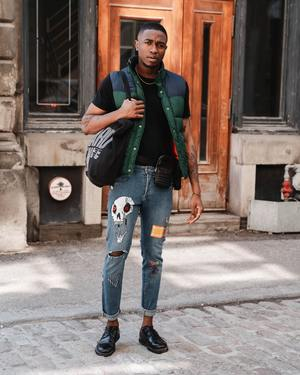

In [43]:
pil_img.fromarray(
    np.uint8(
        hd_imgs[0] * 255
    )
)


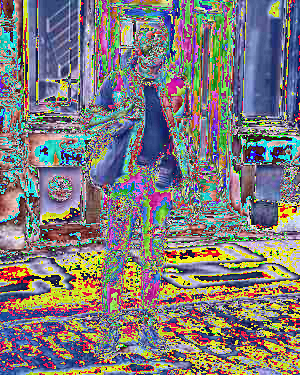

In [11]:
pil_img.fromarray(
    np.uint8(
        # np.rollaxis(body_imgs[0].numpy(), 0, 3) * 255
        np.rollaxis(full_imgs_list[0].numpy(), 0, 3) * 255
    )[:, :, :3]
)


In [10]:
full_imgs_list[0].shape

torch.Size([3, 375, 300])

In [47]:
np.rollaxis(body_imgs[0], 0, 3)[:, :, :3].shape

(256, 256, 3)

In [26]:
body_imgs.shape

(1, 4, 256, 256)

In [ ]:
# python demo.py \
#     --save-vis true \
#     --save-params true \
#     --save-mesh true \
#     --split test \
#     --datasets openpose \
#     --output-folder ../samples/shapy_fit/ \
#     --exp-cfg configs/b2a_expose_hrnet_demo.yaml \
#     --exp-opts \
#         output_folder=../data/trained_models/shapy/SHAPY_A \
#         part_key=pose \
#         datasets.pose.openpose.data_folder=../samples \
#         datasets.pose.openpose.img_folder=images \
#         datasets.pose.openpose.keyp_folder=openpose \
#         datasets.batch_size=1 \
#         datasets.pose_shape_ratio=1.0